In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Change to repo root directory (parent of 'analysis' folder)
# In Jupyter, we can use the notebook's directory or go up from current directory
current_dir = Path.cwd()
if current_dir.name == 'analysis':
    # If we're in the analysis folder, go up one level
    repo_root = current_dir.parent
elif 'analysis' in current_dir.parts:
    # If analysis is in the path, find repo root
    idx = current_dir.parts.index('analysis')
    repo_root = Path(*current_dir.parts[:idx])
else:
    # Otherwise, assume we're already at repo root or need to navigate
    repo_root = Path('/Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis')

os.chdir(repo_root)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis


In [2]:
# Read CSV, skipping the extra header rows (TrackMate exports have multiple header rows)
# Row 0: actual column names (keep as header)
# Row 1-3: descriptive headers we want to skip
edges_path = 'results/trial_3/20260206_224003_subset_edges.csv'
spots_path = 'results/trial_3/20260206_224003_subset_spots.csv'
edges = pd.read_csv(edges_path, header=0, skiprows=[1, 2, 3])  # Keep row 0 as header, skip rows 1-3
spots = pd.read_csv(spots_path, header=0, skiprows=[1, 2, 3])

print(f"DataFrame shape: {edges.shape}")
print(f"\nColumns: {edges.columns.tolist()}")
edges.head()

DataFrame shape: (10719, 13)

Columns: ['LABEL', 'TRACK_ID', 'SPOT_SOURCE_ID', 'SPOT_TARGET_ID', 'LINK_COST', 'DIRECTIONAL_CHANGE_RATE', 'SPEED', 'DISPLACEMENT', 'EDGE_TIME', 'EDGE_X_LOCATION', 'EDGE_Y_LOCATION', 'EDGE_Z_LOCATION', 'MANUAL_EDGE_COLOR']


,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,EDGE_Y_LOCATION,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,249.699022,0.0,NaN
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,249.642027,0.0,NaN
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,249.646044,0.0,NaN
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,250.393479,0.0,NaN
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,248.905988,0.0,NaN


In [3]:
spots.head()

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_Y0,ELLIPSE_MAJOR,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,SHAPE_INDEX
0,ID555081,555081,0,256.0,190.285113,249.124595,0.0,2.0,2,9.053441,...,0.312021,10.501882,8.393338,1.116109,1.251216,257.5,69.509440,0.669730,0.894097,4.331668
1,ID554826,554826,0,321.0,191.558489,250.710663,0.0,0.0,0,10.124020,...,0.327645,13.686488,7.861003,0.975135,1.741061,322.0,86.968336,0.534987,0.824584,4.846556
2,ID555274,555274,0,261.0,191.494220,250.146757,0.0,5.0,5,9.088532,...,0.143661,11.585449,7.554834,0.967845,1.533515,259.5,84.043829,0.461674,0.803406,5.217196
3,ID557258,557258,0,298.0,193.309764,250.383838,0.0,16.0,16,9.723067,...,0.411175,12.673752,8.003717,0.935217,1.583483,297.0,85.337007,0.512497,0.838983,4.951755
4,ID554635,554635,0,261.0,190.137349,248.687380,0.0,1.0,1,9.123488,...,-0.032827,10.472385,8.168952,1.146933,1.281974,261.5,71.671677,0.639715,0.874582,4.432122


## Merge Edges with Spots
- Inner joins to get positions and times of the target spots and source spots for each row

In [4]:
# merge edges with spots twice

# Select only the columns we need from spots (position and time)
spot_cols_needed = ['ID', 'POSITION_X', 'POSITION_Y', 'POSITION_T']

# First merge: get source spot positions
merged = edges.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_SOURCE_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_source' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_source',
    'POSITION_Y': 'POSITION_Y_source', 
    'POSITION_T': 'POSITION_T_source'
})
# Drop the 'ID' column from spots (we don't need it anymore)
merged = merged.drop(columns=['ID'])

# Second merge: get target spot positions
merged = merged.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_TARGET_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_target' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_target',
    'POSITION_Y': 'POSITION_Y_target',
    'POSITION_T': 'POSITION_T_target'
})
# Drop the 'ID' column again
merged = merged.drop(columns=['ID'])

In [5]:
merged.head().iloc[:, -6:]

,POSITION_X_source,POSITION_Y_source,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target
0,191.558489,250.710663,0.0,190.137349,248.687380,1.0
1,190.285113,249.124595,2.0,191.727027,250.159459,3.0
2,191.727027,250.159459,3.0,191.460094,249.132629,4.0
3,191.419975,250.091052,8.0,192.156140,250.695906,9.0
4,190.137349,248.687380,1.0,190.285113,249.124595,2.0


## Calculate Velocity Components
- Note: Units are currently in pixels per frame

In [6]:
delta_T = merged['POSITION_T_target'] - merged['POSITION_T_source']
# Fix: Need parentheses around the position difference before dividing by delta_T
merged['V_x'] = (merged['POSITION_X_target'] - merged['POSITION_X_source']) / delta_T
merged['V_y'] = (merged['POSITION_Y_target'] - merged['POSITION_Y_source']) / delta_T

In [7]:
merged.head()

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,...,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR,POSITION_X_source,POSITION_Y_source,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target,V_x,V_y
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,...,0.0,NaN,191.558489,250.710663,0.0,190.137349,248.687380,1.0,-1.421140,-2.023282
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,...,0.0,NaN,190.285113,249.124595,2.0,191.727027,250.159459,3.0,1.441914,1.034864
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,...,0.0,NaN,191.727027,250.159459,3.0,191.460094,249.132629,4.0,-0.266933,-1.026830
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,...,0.0,NaN,191.419975,250.091052,8.0,192.156140,250.695906,9.0,0.736166,0.604854
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,...,0.0,NaN,190.137349,248.687380,1.0,190.285113,249.124595,2.0,0.147765,0.437215


In [8]:
# validate VELOCITY == SPEED 
merged['VELOCITY'] = np.sqrt(merged['V_x'] ** 2 + merged['V_y'] ** 2)
print('Magnitude of velocity and speed are equal: ' + str(all(np.isclose(np.abs(merged['VELOCITY']), merged['SPEED'], rtol=1e-05))))

Magnitude of velocity and speed are equal: True


## Image Coordinate System to Standard Coordinate System
ImageJ/TrackMate uses image coordinates, not mathematical coordinates:
- Origin (0, 0) is at the top-left corner of the image
- X-axis: increases to the right (positive = right, negative = left)
- Y-axis: increases downward (positive = down, negative = up)

### 1. Convert velocity components to correct units

In [9]:
# 1 pixel = 3.731309 μm
# 1 frame = 15 seconds (from README)
pixel_to_micron = 3.731309
seconds_per_frame = 15
merged['V_x'] = merged['V_x'] * pixel_to_micron / seconds_per_frame 
merged['V_y'] = merged['V_y'] * pixel_to_micron / seconds_per_frame * -1 # negate y for the standard coordinate system

### 2. Get wave velocity direction

In [10]:
# unit vector direction components of the wave
wave_x_unit = -0.875
wave_y_unit = -0.485

### 3. Compute Cosine between velocity and wave (dot product)

In [11]:
# Normalize velocity to unit vector
V_x = merged['V_x']
V_y = merged['V_y']

velocity_magnitude = np.sqrt(V_x**2 + V_y**2)
V_x_unit = V_x / velocity_magnitude
V_y_unit = V_y / velocity_magnitude

# Dot product with wave unit vector
merged['cosine'] = V_x_unit * wave_x_unit + V_y_unit * wave_y_unit

# Sort by closest to 1 (most aligned)
sorted_by_alignment = merged.sort_values('cosine', ascending=False)
sorted_by_alignment['cosine']

10583    1.000424
8100     1.000424
1906     1.000424
1623     1.000424
5030     1.000423
           ...   
1166    -1.000424
2447    -1.000424
460     -1.000424
8040    -1.000425
5127    -1.000425
Name: cosine, Length: 10719, dtype: float64

## Exploratory Data Analysis

### Cosine Analysis

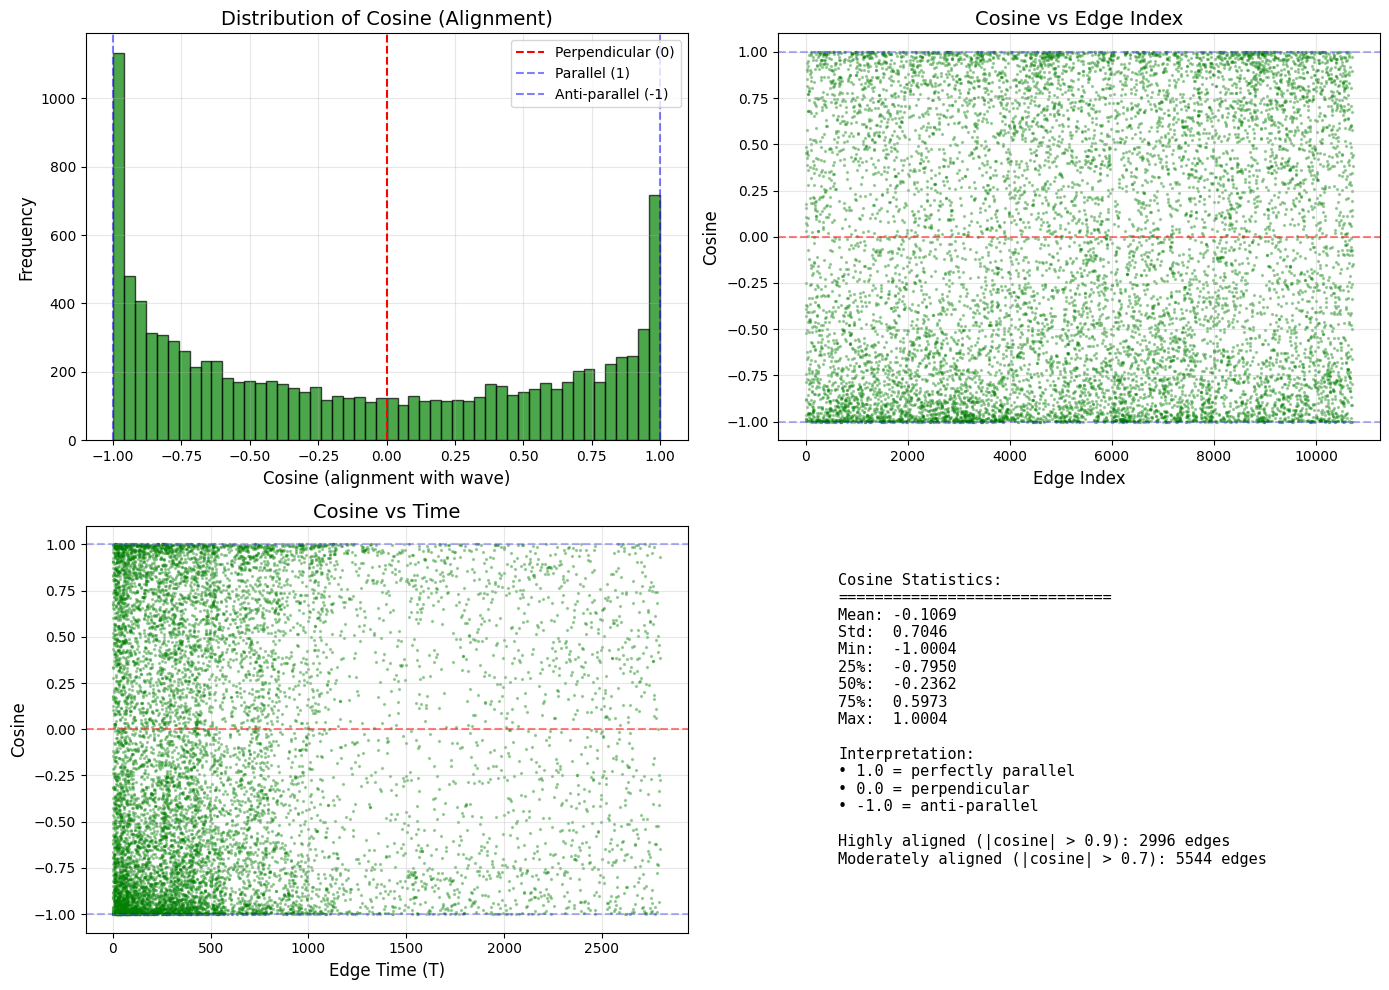

In [12]:
# Visualize cosine (alignment with wave direction)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of cosine values
axes[0, 0].hist(merged['cosine'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 0].set_xlabel('Cosine (alignment with wave)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Cosine (Alignment)', fontsize=14)
axes[0, 0].axvline(0, color='red', linestyle='--', label='Perpendicular (0)')
axes[0, 0].axvline(1, color='blue', linestyle='--', alpha=0.5, label='Parallel (1)')
axes[0, 0].axvline(-1, color='blue', linestyle='--', alpha=0.5, label='Anti-parallel (-1)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Cosine vs Edge Index
axes[0, 1].scatter(merged.index, merged['cosine'], alpha=0.3, s=2, color='green')
axes[0, 1].set_xlabel('Edge Index', fontsize=12)
axes[0, 1].set_ylabel('Cosine', fontsize=12)
axes[0, 1].set_title('Cosine vs Edge Index', fontsize=14)
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(1, color='blue', linestyle='--', alpha=0.3)
axes[0, 1].axhline(-1, color='blue', linestyle='--', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# Cosine vs Time
if 'EDGE_TIME' in merged.columns:
    T = merged['EDGE_TIME']
    time_label = 'Edge Time (T)'
else:
    T = (merged['POSITION_T_source'] + merged['POSITION_T_target']) / 2
    time_label = 'Time (T) - Midpoint'

axes[1, 0].scatter(T, merged['cosine'], alpha=0.3, s=2, color='green')
axes[1, 0].set_xlabel(time_label, fontsize=12)
axes[1, 0].set_ylabel('Cosine', fontsize=12)
axes[1, 0].set_title('Cosine vs Time', fontsize=14)
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(1, color='blue', linestyle='--', alpha=0.3)
axes[1, 0].axhline(-1, color='blue', linestyle='--', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3)

# Statistics summary
cosine_stats = merged['cosine'].describe()
axes[1, 1].axis('off')
stats_text = f"""Cosine Statistics:
{'='*30}
Mean: {cosine_stats['mean']:.4f}
Std:  {cosine_stats['std']:.4f}
Min:  {cosine_stats['min']:.4f}
25%:  {cosine_stats['25%']:.4f}
50%:  {cosine_stats['50%']:.4f}
75%:  {cosine_stats['75%']:.4f}
Max:  {cosine_stats['max']:.4f}

Interpretation:
• 1.0 = perfectly parallel
• 0.0 = perpendicular
• -1.0 = anti-parallel

Highly aligned (|cosine| > 0.9): {((merged['cosine'].abs() > 0.9).sum())} edges
Moderately aligned (|cosine| > 0.7): {((merged['cosine'].abs() > 0.7).sum())} edges
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
                verticalalignment='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

Since the wave propagates down and to the left, it would make sense for the **cosine of the instantaneous edge velocities** to be *more* negative, as it should move not with the wave but in the opposite direction of the wave, towards its origin (top right). Any amount of **anti-parallelism** is what we're looking for.

### Parallelism and Orthogonality Analysis

In [13]:
# Parallel component (along wave direction)
merged['V_parallel'] = V_x * wave_x_unit + V_y * wave_y_unit

# Orthogonal component (projection/perpendicular to wave)
merged['V_orthogonal'] = V_x * (-wave_y_unit) + V_y * wave_x_unit  # rotate wave vector 90°

In [14]:
# Extract V_parallel and V_orthogonal as Series
V_parallel = merged['V_parallel']
V_orthogonal = merged['V_orthogonal']

print(f"V_parallel: {len(V_parallel)} values")
print(f"V_orthogonal: {len(V_orthogonal)} values")
print(f"\nV_parallel stats:")
print(V_parallel.describe())
print(f"\nV_orthogonal stats:")
print(V_orthogonal.describe())

V_parallel: 10719 values
V_orthogonal: 10719 values

V_parallel stats:
count    10719.000000
mean        -0.017521
std          0.225962
min         -4.520296
25%         -0.085466
50%         -0.015807
75%          0.049443
max          4.147707
Name: V_parallel, dtype: float64

V_orthogonal stats:
count    10719.000000
mean         0.000543
std          0.216486
min         -4.021742
25%         -0.067162
50%         -0.000768
75%          0.068690
max          3.011412
Name: V_orthogonal, dtype: float64


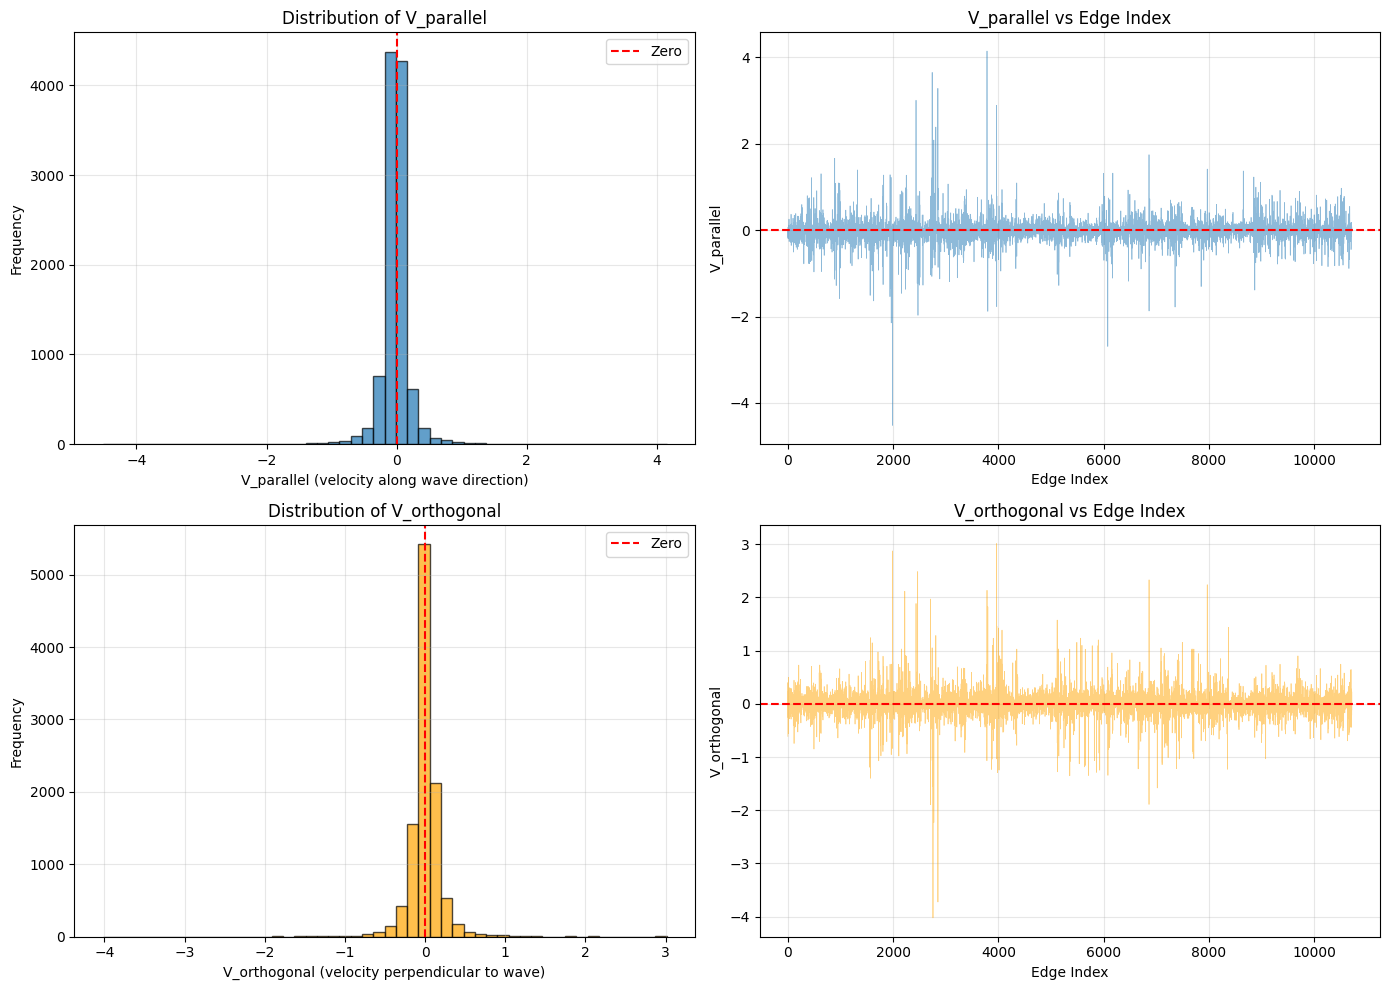

In [15]:
# Create plots for V_parallel and V_orthogonal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# V_parallel plots
axes[0, 0].hist(V_parallel, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('V_parallel (velocity along wave direction)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of V_parallel')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(V_parallel.index, V_parallel.values, alpha=0.5, linewidth=0.5)
axes[0, 1].set_xlabel('Edge Index')
axes[0, 1].set_ylabel('V_parallel')
axes[0, 1].set_title('V_parallel vs Edge Index')
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].grid(True, alpha=0.3)

# V_orthogonal plots
axes[1, 0].hist(V_orthogonal, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('V_orthogonal (velocity perpendicular to wave)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of V_orthogonal')
axes[1, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(V_orthogonal.index, V_orthogonal.values, alpha=0.5, linewidth=0.5, color='orange')
axes[1, 1].set_xlabel('Edge Index')
axes[1, 1].set_ylabel('V_orthogonal')
axes[1, 1].set_title('V_orthogonal vs Edge Index')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

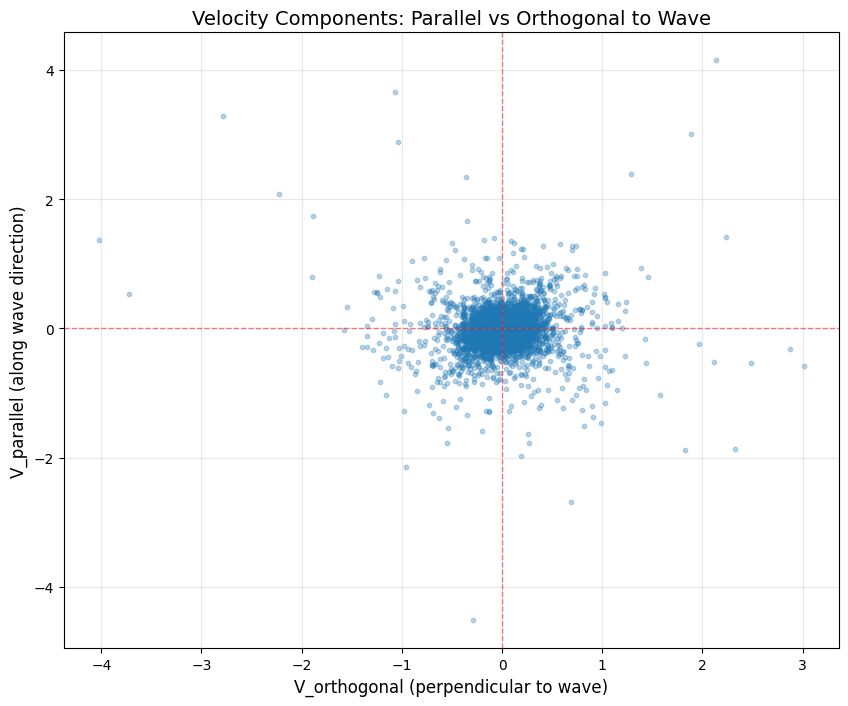

Quadrant Analysis:
Q1 (V_orthogonal > 0, V_parallel > 0): 2528 edges
Q2 (V_orthogonal < 0, V_parallel > 0): 2113 edges
Q3 (V_orthogonal < 0, V_parallel < 0): 3278 edges
Q4 (V_orthogonal > 0, V_parallel < 0): 2800 edges


In [16]:
# Scatter plot: V_parallel vs V_orthogonal
plt.figure(figsize=(10, 8))
plt.scatter(V_orthogonal, V_parallel, alpha=0.3, s=10)
plt.xlabel('V_orthogonal (perpendicular to wave)', fontsize=12)
plt.ylabel('V_parallel (along wave direction)', fontsize=12)
plt.title('Velocity Components: Parallel vs Orthogonal to Wave', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# Print quadrant analysis
print("Quadrant Analysis:")
print(f"Q1 (V_orthogonal > 0, V_parallel > 0): {((V_orthogonal > 0) & (V_parallel > 0)).sum()} edges")
print(f"Q2 (V_orthogonal < 0, V_parallel > 0): {((V_orthogonal < 0) & (V_parallel > 0)).sum()} edges")
print(f"Q3 (V_orthogonal < 0, V_parallel < 0): {((V_orthogonal < 0) & (V_parallel < 0)).sum()} edges")
print(f"Q4 (V_orthogonal > 0, V_parallel < 0): {((V_orthogonal > 0) & (V_parallel < 0)).sum()} edges")

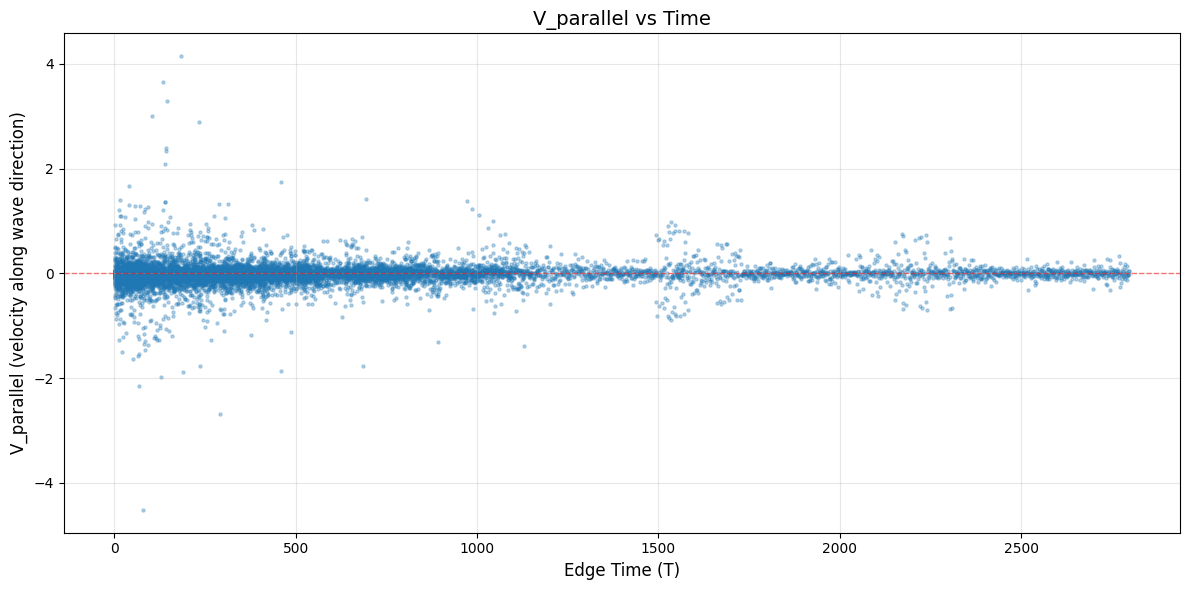

In [17]:
# Use EDGE_TIME if available, otherwise use average of source and target times
if 'EDGE_TIME' in merged.columns:
    T = merged['EDGE_TIME']
    time_label = 'Edge Time (T)'
else:
    # Use midpoint time between source and target
    T = (merged['POSITION_T_source'] + merged['POSITION_T_target']) / 2
    time_label = 'Time (T) - Midpoint'

# Plot V_parallel vs Time
plt.figure(figsize=(12, 6))
plt.scatter(T, V_parallel.values, alpha=0.3, s=5)
plt.xlabel(time_label, fontsize=12)
plt.ylabel('V_parallel (velocity along wave direction)', fontsize=12)
plt.title('V_parallel vs Time', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
tracks_path = 'results/trial_3/20260206_224003_subset_tracks.csv'
tracks = pd.read_csv(tracks_path, header=0, skiprows=[1, 2, 3])
longest_track_id = tracks.sort_values('TRACK_DISPLACEMENT', ascending=False).head()['TRACK_ID'].iloc[0]

In [19]:
merged[merged['TRACK_ID'] == longest_track_id].head().sort_values('LABEL')

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,...,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target,V_x,V_y,VELOCITY,cosine,V_parallel,V_orthogonal
2875,ID597676 → ID598186,186,597676,598186,0.102590,2.493623,0.119290,0.119290,265.5,281.686683,...,265.0,281.627043,348.419804,266.0,-0.029671,0.000401,0.119290,0.868366,0.025768,-0.014741
2872,ID608506 → ID607829,186,608506,607829,0.029154,1.386771,0.059939,0.059939,328.5,297.217997,...,328.0,297.247812,341.516866,329.0,0.014833,0.001511,0.059939,-0.919643,-0.013712,0.005872
2876,ID613687 → ID613018,186,613687,613018,0.752098,2.681170,0.499268,0.499268,358.5,302.234765,...,358.0,302.164141,338.494164,359.0,-0.035136,-0.119121,0.499268,0.712733,0.088518,0.087190
2873,ID616389 → ID615347,186,616389,615347,0.252309,1.687260,0.568712,0.568712,372.5,305.167878,...,372.0,305.446896,335.515906,373.0,0.138813,-0.027284,0.568712,-0.765036,-0.108229,0.091198
2874,ID617953 → ID618677,186,617953,618677,0.164998,0.963050,0.530395,0.530395,388.5,310.164740,...,388.0,310.252403,331.925913,389.0,0.043613,0.124521,0.530395,-0.746974,-0.098554,-0.087804


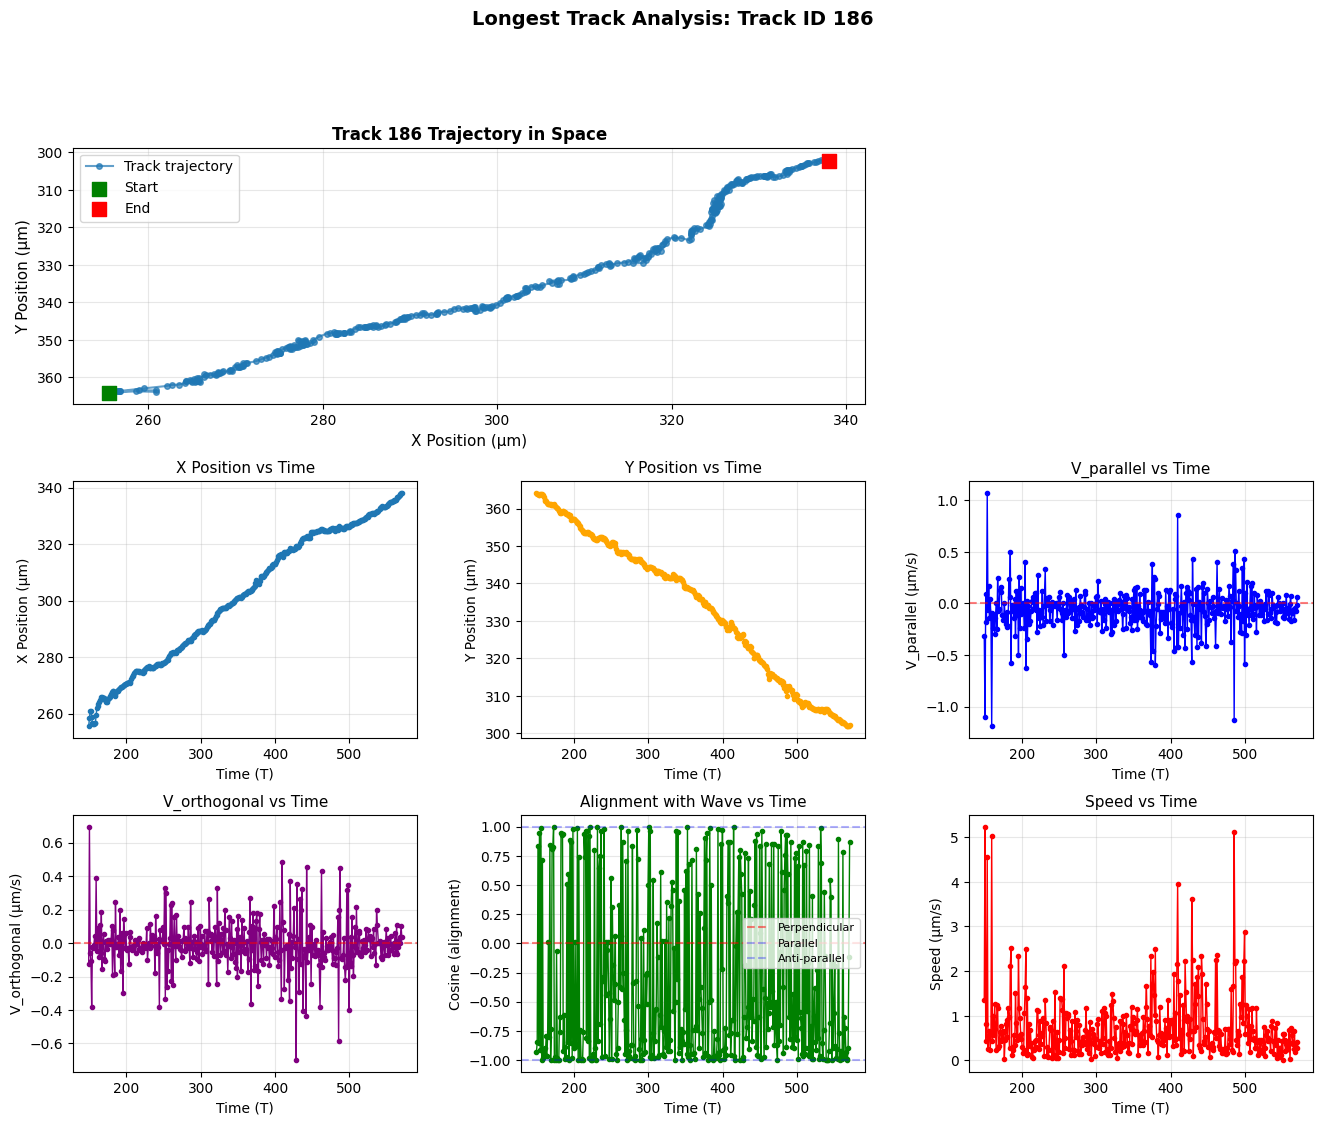

Track 186 Summary:
Edges: 419
Time range: 149.5 - 570.5
Displacement: 103.63 μm
Mean V_parallel: -0.061 μm/s
Mean V_orthogonal: -0.008 μm/s
Mean cosine: -0.319
Mean speed: 0.731 μm/s



In [20]:
# Visualize longest track - comprehensive view
longest_track = merged[merged['TRACK_ID'] == longest_track_id].copy().sort_values('EDGE_TIME' if 'EDGE_TIME' in merged.columns else 'POSITION_T_source')

# Get time axis
if 'EDGE_TIME' in longest_track.columns:
    T_track = longest_track['EDGE_TIME']
else:
    T_track = (longest_track['POSITION_T_source'] + longest_track['POSITION_T_target']) / 2

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Trajectory in X-Y space (top-left, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(longest_track['EDGE_X_LOCATION'], longest_track['EDGE_Y_LOCATION'], 
         'o-', markersize=4, linewidth=1.5, alpha=0.7, label='Track trajectory')
ax1.scatter(longest_track['EDGE_X_LOCATION'].iloc[0], longest_track['EDGE_Y_LOCATION'].iloc[0],
           s=100, color='green', marker='s', label='Start', zorder=5)
ax1.scatter(longest_track['EDGE_X_LOCATION'].iloc[-1], longest_track['EDGE_Y_LOCATION'].iloc[-1],
           s=100, color='red', marker='s', label='End', zorder=5)
ax1.set_xlabel('X Position (μm)', fontsize=11)
ax1.set_ylabel('Y Position (μm)', fontsize=11)
ax1.set_title(f'Track {longest_track_id} Trajectory in Space', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.invert_yaxis()  # Image coordinates: Y increases downward

# 2. Position X vs Time (middle-left)
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(T_track, longest_track['EDGE_X_LOCATION'], 'o-', markersize=3, linewidth=1)
ax2.set_xlabel('Time (T)', fontsize=10)
ax2.set_ylabel('X Position (μm)', fontsize=10)
ax2.set_title('X Position vs Time', fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Position Y vs Time (middle-center)
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(T_track, longest_track['EDGE_Y_LOCATION'], 'o-', markersize=3, linewidth=1, color='orange')
ax3.set_xlabel('Time (T)', fontsize=10)
ax3.set_ylabel('Y Position (μm)', fontsize=10)
ax3.set_title('Y Position vs Time', fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. V_parallel vs Time (middle-right)
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(T_track, longest_track['V_parallel'], 'o-', markersize=3, linewidth=1, color='blue')
ax4.axhline(0, color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('Time (T)', fontsize=10)
ax4.set_ylabel('V_parallel (μm/s)', fontsize=10)
ax4.set_title('V_parallel vs Time', fontsize=11)
ax4.grid(True, alpha=0.3)

# 5. V_orthogonal vs Time (bottom-left)
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(T_track, longest_track['V_orthogonal'], 'o-', markersize=3, linewidth=1, color='purple')
ax5.axhline(0, color='red', linestyle='--', alpha=0.5)
ax5.set_xlabel('Time (T)', fontsize=10)
ax5.set_ylabel('V_orthogonal (μm/s)', fontsize=10)
ax5.set_title('V_orthogonal vs Time', fontsize=11)
ax5.grid(True, alpha=0.3)

# 6. Cosine (alignment) vs Time (bottom-center)
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(T_track, longest_track['cosine'], 'o-', markersize=3, linewidth=1, color='green')
ax6.axhline(0, color='red', linestyle='--', alpha=0.5, label='Perpendicular')
ax6.axhline(1, color='blue', linestyle='--', alpha=0.3, label='Parallel')
ax6.axhline(-1, color='blue', linestyle='--', alpha=0.3, label='Anti-parallel')
ax6.set_xlabel('Time (T)', fontsize=10)
ax6.set_ylabel('Cosine (alignment)', fontsize=10)
ax6.set_title('Alignment with Wave vs Time', fontsize=11)
ax6.set_ylim(-1.1, 1.1)
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 7. Speed vs Time (bottom-right)
ax7 = fig.add_subplot(gs[2, 2])
ax7.plot(T_track, longest_track['SPEED'], 'o-', markersize=3, linewidth=1, color='red')
ax7.set_xlabel('Time (T)', fontsize=10)
ax7.set_ylabel('Speed (μm/s)', fontsize=10)
ax7.set_title('Speed vs Time', fontsize=11)
ax7.grid(True, alpha=0.3)

plt.suptitle(f'Longest Track Analysis: Track ID {longest_track_id}', fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Add summary text
track_info = f"""Track {longest_track_id} Summary:
{'='*40}
Edges: {len(longest_track)}
Time range: {T_track.min():.1f} - {T_track.max():.1f}
Displacement: {tracks[tracks['TRACK_ID']==longest_track_id]['TRACK_DISPLACEMENT'].iloc[0]:.2f} μm
Mean V_parallel: {longest_track['V_parallel'].mean():.3f} μm/s
Mean V_orthogonal: {longest_track['V_orthogonal'].mean():.3f} μm/s
Mean cosine: {longest_track['cosine'].mean():.3f}
Mean speed: {longest_track['SPEED'].mean():.3f} μm/s
"""
print(track_info)

## Velocities with respect to centroid 

In [21]:
centroid_x = 270
centroid_y = 309 

## Futher Cosine Analysis

In [22]:
sorted_by_cosine = merged[merged['cosine'] >= 0.9].sort_values(['cosine', 'EDGE_TIME'], ascending=False)

In [23]:
sorted_by_cosine.head()

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,...,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target,V_x,V_y,VELOCITY,cosine,V_parallel,V_orthogonal
10583,ID904351 → ID904228,361,904351,904228,0.717328,2.625853,0.587243,0.587243,2391.5,266.363047,...,2391.0,266.106368,308.721316,2392.0,-0.127700,-0.070935,0.587243,1.000424,0.146141,0.000134
8100,ID711870 → ID712202,333,711870,712202,0.106127,2.376068,0.212825,0.212825,949.5,384.609759,...,949.0,384.516760,426.313780,950.0,-0.046268,-0.025730,0.212825,1.000424,0.052963,0.000074
1906,ID569739 → ID569394,84,569739,569394,0.144552,2.174526,0.159554,0.159554,93.5,205.707174,...,93.0,205.637456,245.492822,94.0,-0.034685,-0.019292,0.159554,1.000424,0.039706,0.000058
1623,ID560403 → ID560397,51,560403,560397,1.328751,1.882664,0.213909,0.213909,33.5,189.207009,...,33.0,189.113379,317.959516,34.0,-0.046581,-0.025721,0.213909,1.000424,0.053233,-0.000086
5030,ID615134 → ID614807,239,615134,614807,0.685714,1.458181,0.847803,0.847803,369.5,212.342672,...,369.0,211.971494,348.205142,370.0,-0.184664,-0.101861,0.847803,1.000423,0.210983,-0.000434
